In [15]:
# import the required libraries:
import sentencepiece as spm
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import torch
import torch.nn as nn
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt



### Parameters for Tokenizer + LSTM

In [16]:
#Execute this script to set values for different parameters:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES = 256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
VOCAB_SIZE = 10000
# 200 = dimension of the GloVe word embeddings
EMBEDDING_SIZE = 200
NUM_EPOCHS = 20

This is a Neural Machine Translation  translation model that will translate English sentences into their French language counterparts. To develop such a model, I will be pulling from a dataset of 20,000 verified sentence translations. These translations are the ground truth where the weights of my network will be backpropgated from, comparing prediction sentence output against the real labels. 

# Data Preprocessing

We need to generate two copies of the translated sentence: one with the start-of-sentence token and the other with the end-of-sentence token.



In [17]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open('C:\\Users\\Andrew\\Desktop\\nasa_project\\Juliet\\Large Files\\fra.txt', encoding="utf-8"):
    count += 1
    if count > NUM_SENTENCES:
        break
    if '\t' not in line:
        continue
    input_sentence = line.rstrip().split('\t')[0]
    output = line.rstrip().split('\t')[1]

    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Number of sample input:", len(input_sentences))
print("Number of sample output:", len(output_sentences))
print("Number of sample output input:", len(output_sentences_inputs))

Number of sample input: 20000
Number of sample output: 20000
Number of sample output input: 20000


Randomly printing the same indexed input and output sentence to verify they make sense. 

In [18]:
print("English sentence: ",input_sentences[180])
print("French translation: ",output_sentences[180])

English sentence:  Be fair.
French translation:  Soyez honnêtes. <eos>


## Preprocessing 


The next step is tokenizing the original and translated sentences and applying padding to the sentences that are longer or shorter than a certain length, which in case of inputs will be the length of the longest input sentence. And for the output this will be the length of the longest sentence in the output.

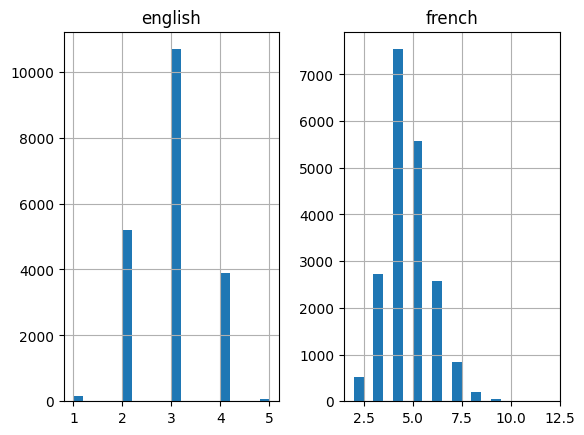

298145
513364
513364


In [19]:
# let’s visualise the length of the sentences.
import pandas as pd

eng_len = []
fren_len = []

# populate the lists with sentence lengths
for i in input_sentences:
      eng_len.append(len(i.split()))

for i in output_sentences:
      fren_len.append(len(i.split()))

length_df = pd.DataFrame({'english':eng_len, 'french':fren_len})

length_df.hist(bins = 20)
plt.show()

all_input_sentences = '\n'.join(input_sentences)
all_output_sentences = '\n'.join(output_sentences)
all_output_sentences_inputs = '\n'.join(output_sentences_inputs)
print(len(all_input_sentences))
print(len(all_output_sentences))
print(len(all_output_sentences_inputs))

## SentencePeice Tokenizer


I am instantiating the tokenizer class here for this task but creating all the functions I will need for use in my full application.  Vocabulary size will be increased to 30k if possible, but will test the BPE encoding of these sentences. 

### Helper Functions
1. Encode
2. Decode
3. convert_sentences_to_sequences
4. get_total_unique_words(self)
5. get_length_of_longest_sentence

    





In [20]:
class Tokenizer:
    def __init__(self, name):
        self.name = name
        self.sp = spm.SentencePieceProcessor()
        
    def train(self, iterable_data, vocab_size, model_type):
        spm.SentencePieceTrainer.train(input=iterable_data, model_prefix=self.name, vocab_size=vocab_size, model_type=model_type)
                        
        self.sp.load(f'{self.name}.model')    

    def encode(self, text, t=int):
        return self.sp.encode(text, out_type=t)

    def decode(self, pieces):
        return self.sp.decode(pieces)
    
    def convert_sentences_to_sequences(self, sentences):
        return [self.encode(sentence) for sentence in sentences]

    def get_total_unique_words(self):
        return len(self.sp)

    def get_length_of_longest_sentence(self, sequences):
        return max(len(sequence) for sequence in sequences)



### Training Encoder Tokenizer
See below is the intializiation of the the tokenizer class tailored to the NLP test here. Sentencepeice really seems to have issues handling other formats outside of files, which makes things a little more painful for the full test where VLWs are going to have to be formatted and printed. 

Before passing the data thruogh anything I need to have a dataframe csv start so I can be sure it is possible to line the data indeces up so they can be compared as tensors. 

In [21]:
# Moving all the sentences to a file to make working with sentencepeice easier. 
with open ('C:\\Users\\Andrew\\Desktop\\nasa_project\\Juliet\\Large Files\\eng_sentences.txt', 'w', encoding="utf-8") as f:
    for sentence in input_sentences:
        f.write(sentence + '\n')
with open ('C:\\Users\\Andrew\\Desktop\\nasa_project\\Juliet\\Large Files\\output_sentences.txt', 'w', encoding="utf-8") as f:
    for sentence in output_sentences:
        f.write(sentence + '\n')
with open ('C:\\Users\\Andrew\\Desktop\\nasa_project\\Juliet\\Large Files\\output_sentences_input.txt', 'w', encoding="utf-8") as f:
    for sentence in output_sentences_inputs:
        f.write(sentence + '\n')
        
tokenizer = Tokenizer('eng_to_fra_10k')

file = 'C:\\Users\\Andrew\\Desktop\\nasa_project\\Juliet\\Large Files\\eng_sentences.txt'
input_tokenizer = tokenizer.train( file, VOCAB_SIZE, 'bpe')
input_integer_seq = tokenizer.encode(input_sentences)
print(input_integer_seq)

# Get the total number of unique words
total_unique_words = tokenizer.get_total_unique_words()
print('Total unique words in the input: %s' % total_unique_words)

# Get the length of the longest sentence
max_input_len = tokenizer.get_length_of_longest_sentence(input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

word2idx_inputs = {tokenizer.sp.id_to_piece(id): id for id in range(tokenizer.sp.get_piece_size())}


[[175, 9949], [175, 9949], [175, 9949], [175, 9949], [1836, 9949], [1836, 9949], [688, 9978], [688, 9978], [688, 9978], [688, 9978], [688, 9978], [688, 9978], [688, 9978], [688, 9978], [688, 9949], [688, 9949], [688, 9949], [688, 9949], [688, 9949], [688, 9949], [688, 9949], [688, 9949], [145, 9971], [2972, 9978], [2972, 9978], [2972, 9978], [2608, 9978], [2608, 9978], [2608, 9978], [3038, 9978], [606, 9978], [2306, 9949], [2306, 9949], [2307, 9978], [2307, 9949], [253, 9978], [253, 9978], [253, 9978], [505, 9978], [505, 9978], [505, 9978], [505, 9949], [505, 9949], [505, 9949], [505, 9949], [3823, 9949], [3823, 9949], [175, 144, 9949], [175, 144, 9949], [175, 144, 9949], [1758, 9978], [1758, 9978], [1758, 9949], [1758, 9949], [1758, 9949], [1758, 9949], [3, 179, 9949], [3, 179, 9949], [3, 339, 9949], [3, 292, 9978], [3, 292, 9978], [3, 292, 9949], [2241, 187, 9978], [1206, 9949], [1206, 9949], [1206, 9949], [1206, 9949], [1206, 9949], [1206, 9949], [1206, 9949], [1206, 9949], [1206, 9

### Decoder Tokenizer
Here I am pulling the output sentences and their counterparts to create the decoder portion (training the french output predictions)
Also I am greating a dictionary later to 


In [22]:
tokenizer2 = Tokenizer('fra_to_eng_10k')
file = 'C:\\Users\\Andrew\\Desktop\\nasa_project\\Juliet\\Large Files\\output_sentences.txt'
output_tokenizer = tokenizer2.train( file, VOCAB_SIZE, 'bpe')
output_integer_seq = tokenizer2.encode(output_sentences)
# This is using the trained output model to encode the decoder inputs
output_input_integer_seq = tokenizer2.encode(output_sentences_inputs)
print(output_integer_seq)
print(output_input_integer_seq)

# Create a dictionary where the keys are the tokens and the values are the IDs
word2idx_outputs = {tokenizer2.sp.id_to_piece(id): id for id in range(tokenizer2.sp.get_piece_size())}
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = tokenizer2.get_length_of_longest_sentence(output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)



[[426, 28, 4, 5, 9939], [2808, 9944, 4, 5, 9939], [360, 1131, 28, 4, 5, 9939], [1805, 28, 4, 5, 9939], [1934, 28, 4, 5, 9939], [1934, 9944, 4, 5, 9939], [3120, 28, 4, 5, 9939], [5810, 28, 4, 5, 9939], [443, 902, 2834, 90, 902, 2048, 28, 4, 5, 9939], [3532, 28, 4, 5, 9939], [4320, 28, 4, 5, 9939], [3120, 28, 4, 5, 9939], [4322, 28, 4, 5, 9939], [5811, 28, 4, 5, 9939], [3120, 28, 4, 5, 9939], [5810, 28, 4, 5, 9939], [443, 902, 2834, 90, 902, 2048, 28, 4, 5, 9939], [3532, 28, 4, 5, 9939], [4320, 28, 4, 5, 9939], [3120, 28, 4, 5, 9939], [4322, 28, 4, 5, 9939], [5811, 28, 4, 5, 9939], [173, 27, 4, 5, 9939], [165, 3631, 28, 4, 5, 9939], [9932, 0, 6940, 28, 4, 5, 9939], [9932, 0, 1096, 28, 4, 5, 9939], [591, 2105, 28, 4, 5, 9939], [4450, 9954, 232, 28, 4, 5, 9939], [9721, 9954, 101, 28, 4, 5, 9939], [919, 1303, 28, 4, 5, 9939], [591, 14, 9951, 637, 28, 4, 5, 9939], [3617, 9954, 232, 9944, 4, 5, 9939], [9013, 9954, 101, 9944, 4, 5, 9939], [3625, 9944, 4, 5, 9939], [3625, 9944, 4, 5, 9939], [16

### Post-Tokenization Processing


Now the lengths of longest sentence can also be varified from the histogram above. And it can be concluded that English sentences are normally shorter and contain a smaller number of words on average, compared to the translated French sentences.

Max English sentence length = 9
Max French sentence length = 16

Next, we need to pad the input. The reason behind padding the input and the output is that text sentences can be of varying length, however LSTM expects input instances with the same length. Therefore, we need to convert our sentences into fixed-length vectors. One way to do this is via padding.


In [23]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[180]:", encoder_input_sequences[180])

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[180]:", decoder_input_sequences[180])

decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)
print("decoder_output_sequences[180]:", decoder_output_sequences[180])


encoder_input_sequences.shape: (20000, 9)
encoder_input_sequences[180]: [   0    0    0    0    0    0  143  814 9949]
decoder_input_sequences.shape: (20000, 21)
decoder_input_sequences[180]: [   4 9934    3 9939  290 3892 9944    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]
decoder_output_sequences.shape: (20000, 21)
decoder_output_sequences[180]: [ 290 3892 9944    4    5 9939    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]


# Word Embeddings


We already converted our words into integers. So what's the difference between integer representation and word embeddings?

There are two main differences between single integer representation and word embeddings. With integer reprensentation, a word is represented only with a single integer. With vector representation a word is represented by a vector of 50, 100, 200, or whatever dimensions you like. Hence, word embeddings capture a lot more information about words. Secondly, the single-integer representation doesn't capture the relationships between different words. On the contrary, word embeddings retain relationships between the words. You can either use custom word embeddings or you can use pretrained word embeddings.

For English sentences, i.e. the inputs, we will use the GloVe word embeddings. For the translated French sentences in the output, we will use custom word embeddings.

Let's create word embeddings for the inputs first. To do so, we need to load the GloVe word vectors into memory. We will then create a dictionary where words are the keys and the corresponding vectors are values,

In [24]:
embeddings_dictionary = dict()

glove_file = open(r'C:\\Users\\Andrew\\Desktop\\nasa_project\\Juliet\\Large Files\\glove.twitter.27B.200d.txt', encoding="utf8")

for line in glove_file:
    rec = line.split()
    word = rec[0]
    try:
        vector_dimensions = np.asarray(rec[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
    except ValueError:
        print(f"Error converting line: {line}")
        continue

glove_file.close()

In [25]:
num_words = min(VOCAB_SIZE, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        if embedding_vector.shape[0] != EMBEDDING_SIZE:
            print(f"Warning: The dimension of the embedding vector for word '{word}' does not match the expected size of {EMBEDDING_SIZE}.")
            continue
        embedding_matrix[word2idx_inputs[word]] = embedding_vector
        
print(embedding_matrix[464])

#print(embeddings_dictionary["toast"])


[-1.60060003e-01 -2.05369994e-01 -2.56729990e-01 -3.53999995e-02
  1.77829996e-01 -3.32399994e-01 -5.20510018e-01  2.90369987e-01
 -2.51029998e-01 -9.34460014e-02 -3.13340008e-01  3.96160007e-01
  2.63080001e-01  1.72049999e-01  1.11249998e-01  3.16969991e-01
  2.84370005e-01  4.00029987e-01 -7.65260011e-02  1.31889999e-01
 -3.79249990e-01  4.50690001e-01 -2.61400007e-02 -3.63489985e-02
 -5.66590011e-01 -7.10600019e-01  1.40169993e-01  2.22179994e-01
  3.93260002e-01  4.09459993e-02  7.98140019e-02  4.23020005e-01
  5.09169996e-01  2.12339997e-01  6.95569992e-01 -2.06880003e-01
 -3.24330002e-01  1.92049995e-01  2.26750001e-01  2.27679998e-01
 -1.38720000e+00  1.12310000e-01  2.58659989e-01 -2.31419995e-01
  2.05039993e-01 -6.01639986e-01 -5.17480016e-01  3.25950012e-02
 -1.60209998e-01  1.59549996e-01  4.59369987e-01 -3.91599983e-02
 -2.70670000e-02 -3.79929990e-01  2.34699994e-01 -1.95350006e-01
 -3.95570010e-01 -3.94929983e-02  5.83060026e-01  1.23539999e-01
 -2.77350008e-01  9.04769

## Creating the Model

1. LSTM Model declaration.
2. Intialize weights with the pre-trained Glove embeddings. 
3. Convert encoder and deocder sequences into tensor format, and load them into the training function when ready. 
4. Parameters set here worth noting: Learning Rate = 0.01 Mu for gradient clipping= .25 
5. Make Predictions, pass these on through the layers bi-directionally, update the weights of the hidden layers through back propagation (Implemented via Pytorch)



4. Plot and Visualize. Accuracy and Loss will be shown. 



In [26]:
class Seq2Seq(nn.Module):
    def __init__(self, hidden_dim, lstm_layers, word_vectors, dropout=0.05, bidirectional=True):
        super(Seq2Seq, self).__init__()

        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers
        self.embedding_dim = word_vectors.shape[1]  # Get embedding dimension from word vectors

        # Encoder
        self.encoder_embed = nn.Embedding.from_pretrained(word_vectors, freeze=False)
        self.encoder_lstm = nn.LSTM(self.embedding_dim, hidden_dim, num_layers=lstm_layers, dropout=dropout,
                                    bidirectional=bidirectional, batch_first=True)

        # Decoder
        self.decoder_embed = nn.Embedding.from_pretrained(word_vectors, freeze=False)
        self.decoder_lstm = nn.LSTM(self.embedding_dim, hidden_dim, num_layers=lstm_layers, dropout=dropout,
                                    bidirectional=bidirectional, batch_first=True)
        self.decoder_linear = nn.Linear((2 if bidirectional else 1)*hidden_dim, word_vectors.shape[0])

    def forward(self, source, target):
        # Encoder
        source = self.encoder_embed(source)
        _, hidden = self.encoder_lstm(source)

        # Decoder
        target = self.decoder_embed(target)
        output, _ = self.decoder_lstm(target, hidden)
        output = self.decoder_linear(output)

        return output

Adding in a visualization here 4-17

### LSTM Trainer function
Should be be setup to be generalized to the main project as well. 


In [27]:
def train_seq2seq(model, train_data, name,  lr, mu):
    # Initialize the optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    #New loss history
    loss_history = []
    # Start the training loop
    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0
        #New
        correct = 0
        total = 0
        for i, (src, trg_input, trg_output) in enumerate(train_data):
            optimizer.zero_grad()
        
            # Pass both the source sequence and the input to the decoder to the model
            output = model(src, trg_input)
            
            #New
            output_dim = output.shape[-1]
            output = output.view(-1, trg_input.shape[1], output_dim)
            _, predicted = torch.max(output, 2)
            total += trg_output.nelement()
            correct += predicted.eq(trg_output.data).sum().item()
            
            
            # Flatten the output and target tensors to compute the loss
            #output_dim = output.shape[-1]
            output = output.view(-1, output_dim)
            trg_output = trg_output.view(-1)
        
            loss = criterion(output, trg_output)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=mu)
            optimizer.step()
        
            total_loss += loss.item()
        #NEW
        avg_loss = total_loss / len(train_data)
        loss_history.append(avg_loss)    
        accuracy = 100 * correct / total
        print('Accuracy: %d %%' % accuracy)    

        print(f'Epoch: {epoch+1}, Train Loss: {total_loss / len(train_data)}')

    # Save the model parameters
    torch.save(model.state_dict(), f'{name}.pt')
    #Loss_history new
    return model, loss_history

### Performance Test, Load the Model with our encoder and decoder output

In [28]:
# Initialize everything the model will need as an input, embeddings, and the testing and training validation data. 
torch.manual_seed(691)
word_vectors = torch.tensor(embedding_matrix).float()
#Need to convert the encoder and decoder input + decoder output as a set of tensors
encoder_input_sequences = torch.tensor(encoder_input_sequences).long()
decoder_input_sequences = torch.tensor(decoder_input_sequences).long()
decoder_output_sequences = torch.tensor(decoder_output_sequences).long()
# Create TensorDataset objects
train_data = TensorDataset(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

# Create a DataLoader
train_loader = DataLoader(train_data, batch_size=50, shuffle=True)

Juliet = Seq2Seq( 
    hidden_dim=LSTM_NODES, 
    lstm_layers=2, 
    word_vectors= word_vectors ,  
    dropout=0.05, 
    bidirectional=True
)

# Juliet, loss_history = train_seq2seq(Juliet, train_loader, 'Juliet', lr=0.01, mu=0.25)
# plt.plot(loss_history)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.show()

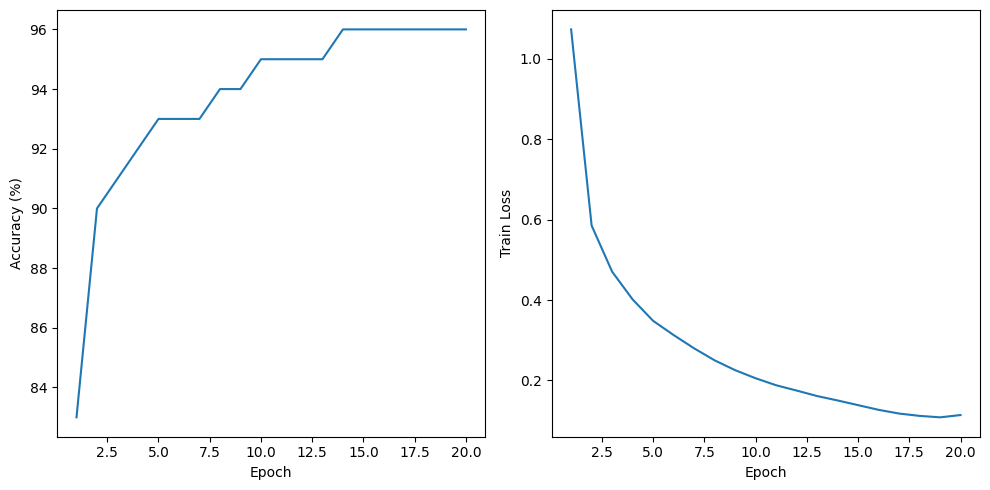

In [29]:
import re
text = """
Accuracy: 83 %
Epoch: 1, Train Loss: 1.0735950461030006
Accuracy: 90 %
Epoch: 2, Train Loss: 0.5855319115519524
Accuracy: 91 %
Epoch: 3, Train Loss: 0.4707811664044857
Accuracy: 92 %
Epoch: 4, Train Loss: 0.4016519380360842
Accuracy: 93 %
Epoch: 5, Train Loss: 0.3483847942203283
Accuracy: 93 %
Epoch: 6, Train Loss: 0.313021829649806
Accuracy: 93 %
Epoch: 7, Train Loss: 0.2800120496749878
Accuracy: 94 %
Epoch: 8, Train Loss: 0.2500889671221376
Accuracy: 94 %
Epoch: 9, Train Loss: 0.2256576169654727
Accuracy: 95 %
Epoch: 10, Train Loss: 0.20552019335329533
Accuracy: 95 %
Epoch: 11, Train Loss: 0.18811588387936354
Accuracy: 95 %
Epoch: 12, Train Loss: 0.17490551432594656
Accuracy: 95 %
Epoch: 13, Train Loss: 0.16123942429199814
Accuracy: 96 %
Epoch: 14, Train Loss: 0.15026511447504162
Accuracy: 96 %
Epoch: 15, Train Loss: 0.13859382396563888
Accuracy: 96 %
Epoch: 16, Train Loss: 0.12692618975415826
Accuracy: 96 %
Epoch: 17, Train Loss: 0.11766131354495883
Accuracy: 96 %
Epoch: 18, Train Loss: 0.11186457687988877
Accuracy: 96 %
Epoch: 19, Train Loss: 0.10826069012284278
Accuracy: 96 %
Epoch: 20, Train Loss: 0.11390107572078705

"""

# Extract accuracy and loss values
accuracy = [int(s[10:-2]) for s in re.findall(r'Accuracy: \d+ %', text)]
loss = [float(s.split(': ')[-1]) for s in re.findall(r'Epoch: \d+, Train Loss: \d+\.\d+', text)]

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(accuracy) + 1), accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss) + 1), loss)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')

plt.tight_layout()
plt.show()

#### Thoughts

If I were to run this again, I should tweak the loss function so that it will cut off after so many epochs of no substantial difference. I was probably pretty close to that happening as the 20th epoch shows a slight tail. 

I'd like to test this models performance on a replica dataset but just different translation pairs sprinkled in, implementing cross validation to have more "in the wild" experience. Although this went well!

In [33]:
from torchview import draw_graph
import graphviz

encoder_inputs, decoder_inputs, _ = next(iter(train_loader))
input_size = encoder_inputs.shape

model_graph = draw_graph(
    model=Juliet,  
    input_data=(encoder_inputs, decoder_inputs),  
    graph_dir='TB',
    depth=3,
    graph_name='NMT_Model',
    hide_module_functions=True,
    roll=True
)


model_graph.visual_graph
model_graph
model_graph.resize_graph(scale=5.0) # scale as per the view model_graph.visual_graph.render(format='svg') 
model_graph.visual_graph.render(format='png')



(dot.exe:8412): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


'NMT_Model.gv.png'